In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# sequences: array(
#   (x:Array, y:Dictionary)
# )
#
partitions = DataPartitions(
    past_frames=6,
    future_frames=2,
    root="../datasets/arda/04_21_full/",
    partial=0.3
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 2),
    output_dim=(partitions.future_frames, 256, 256, 1), 
    batch_size=16, 
    n_channels=1, 
    shuffle=False,
    deep_shuffle = False,
    buffer_size = 1e3,
    buffer_memory = 100
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0 

100%|██████████| 14/14 [00:02<00:00,  6.90it/s]


In [2]:
X.shape

NameError: name 'X' is not defined

In [3]:
i = 5
plt.matshow(X[0, i, 0, :, :, 0])
plt.matshow(Y[0, i, 1, :, :, 0])

NameError: name 'plt' is not defined

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
sc_img = StandardScaler() # image
sc_btm = StandardScaler() # image

for sample in X_train:
    for batch in sample:
        for frame in batch:
            sc_img.partial_fit(frame[:,:,0])
            #sc_btm.partial_fit(frame[:,:,2])

In [9]:
for s, sample in enumerate(X_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            #X_train[s, b, f, :, :, 2] = sc_btm.transform(frame[:,:,2])
            
print("X_train ready")        

for s, sample in enumerate(X_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            #X_test[s, b, f, :, :, 2] = sc_btm.transform(frame[:,:,2])
            
print("X_test transformed")
            
for s, sample in enumerate(y_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])

print("y_train transformed")

for s, sample in enumerate(y_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            
print("y_test transformed")

X_train ready
X_test transformed
y_train transformed
y_test transformed


In [10]:
X_test.shape

(3, 16, 6, 256, 256, 2)

### Model

In [11]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [12]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [13]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv2d(in_filters, filters, (3, 3), stride, padding=1)
        self.c2 = nn.Conv2d(filters, filters, (3, 3), padding=1)
        self.c3 = nn.Conv2d(in_filters, filters, (1, 1), stride)
        
        self.bn = nn.BatchNorm2d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            residual = self.bn(residual)
            
        return self.activation(residual + y)


In [16]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels, past_frames, future_frames):
        super(Autoencoder, self).__init__()
        

        self.layers = nn.ModuleList([
            nn.Conv2d(channels, 64, (3,3), stride=2, padding=1),
            nn.AvgPool2d((2,2)),
            
            ResNetBlock(in_filters = 64, filters = 64, stride = 2),
            ResNetBlock(in_filters = 64, filters = 64, stride = 2),

            nn.Conv2d(64, 128, (1,1)),
            ResNetBlock(in_filters = 128, filters = 128, stride = 2),
            ResNetBlock(in_filters = 128, filters = 128, stride = 2),

            nn.Conv2d(128, 256, (1,1)),
            ResNetBlock(in_filters = 256, filters = 256, stride = 2),
            ResNetBlock(in_filters = 256, filters = 256, stride = 2),

            nn.Flatten(),


            
            nn.Conv2d(256, 512, (1,1)),
            ResNetBlock(in_filters = 512, filters = 512, stride = 2),
            ResNetBlock(in_filters = 512, filters = 512, stride = 2),
            nn.Dropout(p=0.2),

            nn.ConvTranspose2d(512, 512, (2,2), stride=(2,2)),
            nn.ConvTranspose2d(512, 256, (2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=256),

            nn.ConvTranspose2d(256, 256, (2,2), stride=(2,2)),
            nn.ConvTranspose2d(256, 128, (2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=128),

            nn.ConvTranspose2d(128, 128, (1,2,2), stride=(2,2)),
            nn.ConvTranspose2d(128, 64, (1,2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=64),

            nn.ConvTranspose2d(64, 64, (2,2), stride=(2,2)),
            nn.ConvTranspose2d(64, 64, (1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features=64),
            
            nn.ConvTranspose2d(64, 1, (1,2,2), stride=(1,2,2)),
            
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [18]:
net = Autoencoder(2, 4, 4).to(device)
net(th.Tensor(np.random.random((16, 2, 256, 256))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv2d              16, 64, 128, 128
AvgPool2d           16, 64, 64, 64
ResNetBlock         16, 64, 32, 32
ResNetBlock         16, 64, 16, 16
Conv2d              16, 128, 16, 16
ResNetBlock         16, 128, 8, 8
ResNetBlock         16, 128, 4, 4
Conv2d              16, 256, 4, 4
ResNetBlock         16, 256, 2, 2
ResNetBlock         16, 256, 1, 1
Flatten             16, 256


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [512, 256, 1, 1], but got 2-dimensional input of size [16, 256] instead

In [18]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=10e-3)

In [19]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [20]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [21]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [22]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [23]:
def relative_error(y, y_true):
    return (th.norm(y - y_true, float('inf')) / th.norm(y_true, float('inf')))

In [24]:
losses = []
errors = []
test_errors = []

In [25]:
epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())

        # print("batch {} - loss {}".format(i, loss.item()))

        if epoch % 10 == 0:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            train_err = relative_error(train_out, y_train[i]).item()
            test_err = relative_error(test_out, y_test[i]).item()
        
            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f' %
                  (epoch, i, train_err, test_err))
    
        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

/home/diego/anaconda3/envs/parflood/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16, 1, 2, 256, 256])) that is different to the input size (torch.Size([16, 1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0,     1] train_err: 1.005 	  test_err: 1.000
[0,     2] train_err: 0.988 	  test_err: 0.997
[0,     6] train_err: 0.994 	  test_err: 0.997
[0,     4] train_err: 1.010 	  test_err: 0.981
[0,     0] train_err: 0.990 	  test_err: 1.000
[0,     7] train_err: 1.006 	  test_err: 1.005
[0,     4] train_err: 1.000 	  test_err: 0.995
[0,     1] train_err: 0.999 	  test_err: 1.003
[0,     2] train_err: 0.984 	  test_err: 1.009
[0,     0] train_err: 1.005 	  test_err: 1.005
[0,     5] train_err: 1.023 	  test_err: 1.001
[0,     4] train_err: 1.017 	  test_err: 0.998
[0,     3] train_err: 1.019 	  test_err: 1.011
[0,     5] train_err: 1.011 	  test_err: 0.995
[0,     4] train_err: 1.015 	  test_err: 1.014
[0,     6] train_err: 1.006 	  test_err: 1.006
[0,     6] train_err: 1.007 	  test_err: 1.008
[0,     2] train_err: 1.009 	  test_err: 1.002
[0,     4] train_err: 1.007 	  test_err: 0.999
[0,     2] train_err: 1.009 	  test_err: 0.997
[0,     6] train_err: 0.999 	  test_err: 0.991
[0,     2] tr

KeyboardInterrupt: 

In [ ]:
'''
i = 16
j = 20
plt.matshow(X[i, 0, 0, :, :, 0])
plt.matshow(X[j, 0, 1, :, :, 0])
'''

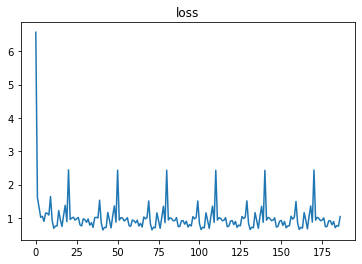

In [26]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

In [ ]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass

In [ ]:
i = np.random.randint(len(X_test))
i

In [ ]:
outputs = net(X_test[i])

In [ ]:
for frame in y_test[i][0][0]:
    plt.matshow(frame.cpu().detach().numpy())

In [ ]:
for frame in outputs[0][0]:
    plt.matshow(frame.cpu().detach().numpy())

In [ ]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))